In [1]:
# 引入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
import random
import time
from tqdm import trange

# Read data

In [2]:
# 讀取資料
train_data = pd.read_csv("/Users/zhuxinrong/Desktop/ML/Dataset/train.csv")
y = train_data["is_claim"]
df = train_data.drop(["policy_id", "is_claim"], axis=1)
df.shape, y.shape

((58592, 42), (58592,))

View type of data

In [3]:
# 檢查資料是否有NA值並刪除id欄位
print(train_data.isna().sum().sum())
print(train_data.shape)
print(train_data.dtypes)

0
(58592, 44)
policy_id                            object
policy_tenure                       float64
age_of_car                          float64
age_of_policyholder                 float64
area_cluster                         object
population_density                    int64
make                                  int64
segment                              object
model                                object
fuel_type                            object
max_torque                           object
max_power                            object
engine_type                          object
airbags                               int64
is_esc                               object
is_adjustable_steering               object
is_tpms                              object
is_parking_sensors                   object
is_parking_camera                    object
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type 

# Data Preprocessing

In [4]:
# 定義資料預處理函數
def preprocess(data):
    dt = data.copy()
    cat = dt.select_dtypes("object")
    conti = dt.select_dtypes(["int64", "float64"])
    cat_col = cat.columns
    conti_col = conti.columns
    for col in cat_col:
        num = cat[col].unique()
        if len(num)==2:
            # "Yes"==1且"No"==0
            if "Yes" in num:
                dt[col] = dt[col].map({"Yes": 1, "No": 0})
            # 無順序之類別則用one hot encoding來轉換
            elif "Drum" in num:
                dt["is_Drum"] = dt[col].map({"Drum": 1, "Disc": 0})
                dt["is_Disc"] = dt[col].map({"Disc": 1, "Drum": 0})
                dt = dt.drop(col, axis=1)
            # 無順序之類別則用one hot encoding來轉換
            else:
                dt["is_Manual"] = dt[col].map({"Manual": 1, "Automatic": 0})
                dt["is_Automatic"] = dt[col].map({"Automatic": 1, "Manual": 0})
                dt = dt.drop(col, axis=1)
        elif len(num)==3:
            # 無順序之類別則用one hot encoding來轉換
            if col=="fuel_type":
                dt["is_CNG"] = dt[col].map({"CNG": 1, "Petrol": 0, "Diesel": 0})
                dt["is_Petrol"] = dt[col].map({"Petrol": 1, "CNG": 0, "Diesel": 0})
                dt = dt.drop(col, axis=1)
            # 無順序之類別則用one hot encoding來轉換
            else:
                dt["is_Power"] = dt[col].map({"Power": 1, "Electric": 0, "Manual": 0})
                dt["is_Electric"] = dt[col].map({"Electric": 1, "Power": 0, "Manual": 0})
                dt = dt.drop(col, axis=1)
        else:
            # 取出扭力值
            if col=="max_torque":
                dic = {}
                for n in num:
                    dic.update({n: float(re.findall(r"-?\d+\.?\d*", n)[0])})
                dt[col] = dt[col].map(dic)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
            # 取出馬力值
            elif col=="max_power":
                dic = {}
                for n in num:
                    dic.update({n: float(re.findall(r"-?\d+\.?\d*", n)[0])})
                dt[col] = dt[col].map(dic)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
            # 其餘變數皆使用frequency encoding來轉換並標準化
            else:
                c = collections.Counter(dt[col])
                dt[col] = dt[col].map(c)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
                
    # 對所有連續變數標準化
    for col in conti_col:
        max = dt[col].max()
        min = dt[col].min()
        dt[col] = (dt[col]-min)/(max-min)
       
    return dt

# Useful Tool

In [5]:
# 定義分割資料函數
def split_data(df, y, valid_proportion, test_proportion, random_state):
    size = df.shape[0]
    test_num = int(size*test_proportion)
    valid_num = int(size*valid_proportion)
    train_num = size-test_num-valid_num
    order = np.array(df.index)
    random.seed(random_state)
    random.shuffle(order)
    train_idx = order[:train_num]
    valid_idx = order[train_num:valid_num+train_num]
    test_idx = order[valid_num+train_num:]

    train_x, valid_x, test_x = df.loc[train_idx], df.loc[valid_idx], df.loc[test_idx]
    train_y, valid_y, test_y = y.loc[train_idx], y.loc[valid_idx], y.loc[test_idx]
    return train_x, valid_x, test_x, train_y, valid_y, test_y

# 定義 RBF 函數
def RBF(x1, x2, gamma=1):
    diff = x1-x2
    # rbf = np.exp(-gamma * np.dot(diff, diff))
    rbf = np.exp(-gamma * (diff**2))
    return rbf


# 建立 kernel 矩陣
def kernel_matrix(X, kernel_func, **kwargs):
    col = X.columns
    newft = {}
    n = 0
    for i in trange(len(col)):
        for j in range(i+1, len(col)):
            name = "Kernel_"+str(n)
            newft[name] = kernel_func(X[col[i]], X[col[j]], **kwargs)
            n += 1
    new_df = pd.DataFrame(newft)
    return new_df

# Spliting data

In [6]:
# 將資料分割成訓練集與測試集
df = preprocess(df)

# 擴展特徵空間至高維度（挑選相關性最高的幾個特徵來進行 kernel 方法）
kernel = kernel_matrix(df[["displacement", "length", "turning_radius", "width"]], RBF, gamma=0.1)

# 合併新特徵至元特徵集
new_df = df.join(kernel)
new_df#.shape

100%|██████████| 4/4 [00:00<00:00, 1062.99it/s]


,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,max_torque,max_power,...,is_Manual,is_Automatic,is_Power,is_Electric,Kernel_0,Kernel_1,Kernel_2,Kernel_3,Kernel_4,Kernel_5
0,0.368130,0.05,0.500000,0.100332,0.064260,0.00,0.941947,1.000000,0.000000,0.000000,...,1,0,1,0,1.000000,0.997961,0.998584,0.997961,0.998584,0.999943
1,0.480580,0.02,0.121622,0.533998,0.365231,0.00,0.941947,1.000000,0.000000,0.000000,...,1,0,1,0,1.000000,0.997961,0.998584,0.997961,0.998584,0.999943
2,0.601457,0.02,0.135135,0.442377,0.051764,0.00,0.941947,1.000000,0.000000,0.000000,...,1,0,1,0,1.000000,0.997961,0.998584,0.997961,0.998584,0.999943
3,0.643904,0.11,0.202703,0.041048,0.291660,0.00,0.137270,0.049160,0.278947,0.617179,...,0,1,0,1,0.999481,0.997967,0.995904,0.995401,0.998298,0.988152
4,0.425902,0.11,0.486486,0.507198,0.470987,0.25,0.941947,0.137813,0.163158,0.342308,...,0,1,0,1,0.999795,0.982090,0.999959,0.985680,0.999938,0.983750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58587,0.252782,0.13,0.500000,1.000000,0.116270,0.25,0.941947,0.137813,0.163158,0.342308,...,0,1,0,1,0.999795,0.982090,0.999959,0.985680,0.999938,0.983750
58588,0.858671,0.02,0.324324,0.262163,0.102516,0.00,0.941947,1.000000,0.000000,0.000000,...,1,0,1,0,1.000000,0.997961,0.998584,0.997961,0.998584,0.999943
58589,0.831862,0.05,0.229730,0.507198,0.470987,0.00,0.941947,1.000000,0.000000,0.000000,...,1,0,1,0,1.000000,0.997961,0.998584,0.997961,0.998584,0.999943
58590,0.884975,0.14,0.378378,1.000000,0.116270,0.00,1.000000,0.919643,0.278947,0.617179,...,1,0,0,1,0.998932,0.997967,0.995904,0.999846,0.990682,0.988152


In [7]:
# 切割訓練集、驗證集與測試集
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(new_df, y, valid_proportion=0.1, test_proportion=0.2, random_state=1121225)
# x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(df, y, valid_proportion=0.1, test_proportion=0.2, random_state=1121225)
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((41015, 52), (5859, 52), (11718, 52), (41015,), (5859,), (11718,))

# 1. Application of Kernel Methods in Ensemble Learning Across Various Learners

### Random Forest Classifier

In [8]:
## Random Forest Classifier
class RandomForestClassifier:
    def __init__(self, threshold=15) -> None:
        self.threshold = threshold

# ---------------------------------------------------------------------------------------------

    # Distinguish categorical and continuous features
    def determine_type_of_feature(self, df):
        
        feature_types = []
        n_unique_values_treshold = self.threshold
        for feature in df.columns:
            if feature != "is_claim": # "label"
                unique_values = df[feature].unique()
                example_value = unique_values[0]

                if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                    feature_types.append("categorical")
                else:
                    feature_types.append("continuous")
        
        return feature_types


    # Accuracy
    def calculate_accuracy(self, y_true, y_pred):
        acc = (y_true==y_pred).mean()
        return acc

    # ---------------------------------------------------------------------------------------------
    # 1. Decision Tree functions with helper function

    # 1.1 Data pure
    def check_purity(self, data):
        
        label_column = data[:, -1]
        unique_classes = np.unique(label_column)

        if len(unique_classes) == 1:
            return True
        else:
            return False

        
    # 1.2 Classify
    def classify_data(self, data):
        
        label_column = data[:, -1]
        unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

        index = counts_unique_classes.argmax()
        classification = unique_classes[index]
        
        return classification


    # 1.3 Potential splits
    def get_potential_splits(self, data, random_subspace):
        
        potential_splits = {}
        _, n_columns = data.shape
        column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
        
        if random_subspace and random_subspace <= len(column_indices):
            column_indices = random.sample(population=column_indices, k=random_subspace)
        
        for column_index in column_indices:          
            values = data[:, column_index]
            unique_values = np.unique(values)
            
            potential_splits[column_index] = unique_values
        
        return potential_splits


    # 1.4 Lowest Overall Entropy
    def calculate_entropy(self, data):
        
        label_column = data[:, -1]
        _, counts = np.unique(label_column, return_counts=True)

        probabilities = counts / counts.sum()
        entropy = sum(probabilities * -np.log2(probabilities))
        
        return entropy


    def calculate_overall_entropy(self, data_below, data_above):
        
        n = len(data_below) + len(data_above)
        p_data_below = len(data_below) / n
        p_data_above = len(data_above) / n

        overall_entropy =  (p_data_below * self.calculate_entropy(data_below) 
                        + p_data_above * self.calculate_entropy(data_above))
        
        return overall_entropy


    def determine_best_split(self, data, potential_splits):
        
        overall_entropy = 9999
        for column_index in potential_splits:
            for value in potential_splits[column_index]:
                data_below, data_above = self.split_data(data, split_column=column_index, split_value=value)
                current_overall_entropy = self.calculate_overall_entropy(data_below, data_above)
                
                if current_overall_entropy <= overall_entropy:
                    overall_entropy = current_overall_entropy
                    best_split_column = column_index
                    best_split_value = value
        
        return best_split_column, best_split_value


    # 1.5 Split data
    def split_data(self, data, split_column, split_value):
        
        split_column_values = data[:, split_column]

        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            data_below = data[split_column_values <= split_value]
            data_above = data[split_column_values >  split_value]
        
        # feature is categorical   
        else:
            data_below = data[split_column_values == split_value]
            data_above = data[split_column_values != split_value]
        
        return data_below, data_above


    # 2. Decision Tree Algorithm
    def decision_tree_algorithm(self, df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
        
        # data preparations
        if counter == 0:
            global COLUMN_HEADERS, FEATURE_TYPES
            COLUMN_HEADERS = df.columns
            FEATURE_TYPES = self.determine_type_of_feature(df)
            data = df.values
        else:
            data = df           
        
        
        # base cases
        if (self.check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
            classification = self.classify_data(data)
            
            return classification

        
        # recursive part
        else:    
            counter += 1

            # helper functions 
            potential_splits = self.get_potential_splits(data, random_subspace)
            split_column, split_value = self.determine_best_split(data, potential_splits)
            data_below, data_above = self.split_data(data, split_column, split_value)
            
            # check for empty data
            if len(data_below) == 0 or len(data_above) == 0:
                classification = self.classify_data(data)
                return classification
            
            # determine question
            feature_name = COLUMN_HEADERS[split_column]
            type_of_feature = FEATURE_TYPES[split_column]
            if type_of_feature == "continuous":
                question = "{} <= {}".format(feature_name, split_value)
                
            # feature is categorical
            else:
                question = "{} = {}".format(feature_name, split_value)
            
            # instantiate sub-tree
            sub_tree = {question: []}
            
            # find answers (recursion)
            yes_answer = self.decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
            no_answer = self.decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
            
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
            
            return sub_tree


    # 3. Make predictions
    # 3.1 One example
    def predict_example(self, example, tree):
            
        question = list(tree.keys())[0]
        feature_name, comparison_operator, value = question.split(" ")

        # ask question
        if comparison_operator == "<=":
            if example[feature_name] <= float(value):
                answer = tree[question][0]
            else:
                answer = tree[question][1]
        
        # feature is categorical
        else:
            if str(example[feature_name]) == value:
                answer = tree[question][0]
            else:
                answer = tree[question][1]

        # base case
        if not isinstance(answer, dict):
            return answer
        
        # recursive part
        else:
            residual_tree = answer
            return self.predict_example(example, residual_tree)

        
    # 3.2 All examples of the test data
    def decision_tree_predictions(self, test_df, tree):
        predictions = test_df.apply(self.predict_example, args=(tree,), axis=1)
        return predictions


    def random_forest_algorithm(self, train_df, n_trees, n_features, dt_max_depth):
        forest = []
        for i in trange(n_trees):
            col = random.sample(list(train_df.iloc[:,:-1].columns), n_features)
            tree = self.decision_tree_algorithm(train_df[col], max_depth=dt_max_depth)
            forest.append(tree)

        return forest

    def random_forest_predictions(self, test_df, forest):
        df_predictions = {}
        for i in range(len(forest)):
            column_name = "tree_{}".format(i)
            predictions = self.decision_tree_predictions(test_df, tree=forest[i])
            df_predictions[column_name] = predictions

        df_predictions = pd.DataFrame(df_predictions)
        
        return df_predictions
    
    def EL_random_forest_predictions(self, test_df, forest):
        df_predictions = {}
        for i in range(len(forest)):
            column_name = "tree_{}".format(i)
            predictions = self.decision_tree_predictions(test_df, tree=forest[i])
            df_predictions[column_name] = predictions

        df_predictions = pd.DataFrame(df_predictions)
        random_forest_predictions = df_predictions.mode(axis=1)[0]

        return random_forest_predictions
    
    def each_trees_accuracy(self, X, trees):
        preds = self.random_forest_predictions(test_df=X, forest=trees)
        y = X.iloc[:,-1]
        accuracy = {}
        for col in preds.columns:
            acc = self.calculate_accuracy(y, preds[col])
            accuracy[col] = acc
            
        return accuracy


#### Training Decision Tree model

In [9]:
RFC = RandomForestClassifier()

# 將特徵與label合併
train_x_y = pd.concat([x_train, y_train], axis=1)
valid_x_y = pd.concat([x_valid, y_valid], axis=1)
test_x_y = pd.concat([x_test, y_test], axis=1)

In [10]:
print(np.unique(train_x_y["is_claim"], return_counts=True))
print(np.unique(valid_x_y["is_claim"], return_counts=True))
print(np.unique(test_x_y["is_claim"], return_counts=True))

(array([0, 1]), array([38371,  2644]))
(array([0, 1]), array([5484,  375]))
(array([0, 1]), array([10989,   729]))


In [11]:
# 訓練隨機森林模型並預測
start = time.time()
forest = RFC.random_forest_algorithm(train_x_y, n_trees=5, n_features=40, dt_max_depth=10)
print("執行時間：{}秒".format(time.time()-start))

100%|██████████| 5/5 [20:22<00:00, 244.59s/it]

執行時間：1222.9663071632385秒


In [12]:
# 驗證集準確率
WL_acc = RFC.each_trees_accuracy(valid_x_y, forest)
WL_acc

{'tree_0': 0.27342549923195086,
 'tree_1': 0.1300563236047107,
 'tree_2': 0.41235705751834784,
 'tree_3': 0.037037037037037035,
 'tree_4': 0.23758320532514082}

### Neural Networks

#### 2 layers MLP

In [13]:
class NeuralNetwork:
    def __init__(self, input_size, layers, output_size, random_seed):
        np.random.seed(random_seed)

        model = {}  #Dictionary

        #First Layer
        model['W1'] = np.random.randn(input_size, layers)
        model['b1'] = np.zeros((1, layers))

        #Second/Output Layer
        model['W2'] = np.random.randn(layers, output_size)
        model['b2'] = np.zeros((1, output_size))
        

        self.model = model
        self.activation_outputs = None

# -------------------- activation function ---------------------- #
    def softmax(self, a):
        e_pa = np.exp(a)
        ans = e_pa / np.sum(e_pa, axis=1, keepdims=True)
        return ans

    def Sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

# ---------------------------- training & prediction --------------------------------- #
    
    # NN process
    def forward(self, x):

        W1, W2 = self.model['W1'], self.model['W2']
        b1, b2 = self.model['b1'], self.model['b2']

        z1 = np.dot(x, W1) + b1
        a1 = np.tanh(z1)

        z2 = np.dot(a1, W2) + b2
        y_ = self.Sigmoid(z2)

        self.activation_outputs = (a1, y_)
        return y_

    # iteration with renew weights
    def backward(self, x, y, learning_rate=0.001):
        W1, W2 = self.model['W1'], self.model['W2']

        a1, y_ = self.activation_outputs

        delta2 = y_ - y
        dw2 = np.dot(a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = (1 - np.square(a1)) * np.dot(delta2, W2.T)
        dw1 = np.dot(x.T, delta1)
        db1 = np.sum(delta1, axis=0)

        #Update the Model Parameters using Gradient Descent
        self.model["W1"] -= learning_rate * dw1
        self.model['b1'] -= learning_rate * db1

        self.model["W2"] -= learning_rate * dw2
        self.model['b2'] -= learning_rate * db2

    # prediction
    def predict(self, x):
        y_out = self.forward(x)
        return np.argmax(y_out, axis=1)

    def summary(self):
        W1, W2 = self.model['W1'], self.model['W2']
        a1, y_ = self.activation_outputs

        print("W1 ", W1.shape)
        print("A1 ", a1.shape)

        print("W2 ", W2.shape)
        print("Y_ ", y_.shape)

    # loss function
    def loss(self, y_oht, p):
        l = -np.mean(y_oht * np.log(p))
        return l

    # one hot encoding function
    def one_hot(self, y, depth):

        m = y.shape[0]
        y_oht = np.zeros((m, depth))
        y_oht[np.arange(m), y] = 1
        return y_oht
    
    # training
    def train(self, X, Y, epochs, learning_rate, logs=True):
        X = np.array(X)
        Y = np.array(Y)
        training_loss = []

        classes = 2
        Y_OHT = self.one_hot(Y, classes)

        for ix in range(epochs):

            Y_ = self.forward(X)
            l = self.loss(Y_OHT, Y_)
            training_loss.append(l)
            self.backward(X, Y_OHT, learning_rate)

            if (logs and ix%50==0):
                print("Epoch %d Loss %.4f" % (ix, l))

        return training_loss
    
    # calculate accuracy
    def accuracy(self, y, pred):
        acc = np.sum(pred == y) / y.shape[0]
        return acc

# ------------------------------------------------- ensemble learning ------------------------------------------------- #
    def EL_forward(self, x, m):

        W1, W2 = m['W1'], m['W2']
        b1, b2 = m['b1'], m['b2']

        z1 = np.dot(x, W1) + b1
        a1 = np.tanh(z1)

        z2 = np.dot(a1, W2) + b2
        y_ = self.Sigmoid(z2)

        self.activation_outputs = (a1, y_)
        return y_
    
    def EL_predict(self, x, m):
        y_out = self.EL_forward(x, m)
        return np.argmax(y_out, axis=1)

    def Ensemble_Learning(self, X, Y, epochs, learning_rate, model_number, n_features, logs=True):
        model_weights = []
        column = []
        losses = []
        for times in trange(model_number):
            col = random.sample(list(X.columns), n_features)
            loss = self.train(X[col], Y, epochs, learning_rate, logs=True)
            model_weights.append(self.model)
            losses.append(loss)
            column.append(col)
        self.models = model_weights
        self.columns = column
            
        return losses
    
    def EL_pred(self, test_df):
        models = self.models
        col = self.columns
        df_predictions = {}
        for i in range(len(models)):
            column_name = "NN_{}".format(i)
            predictions = self.EL_predict(test_df[col[i]], models[i])
            df_predictions[column_name] = predictions

        df_predictions = pd.DataFrame(df_predictions)
        NN_predictions = df_predictions.mode(axis=1)[0].tolist()

        return NN_predictions
        

#### Training NN model

In [14]:
D_in = x_train.shape[1]
NN = NeuralNetwork(input_size=D_in, layers=10, output_size=2, random_seed=1231)

In [15]:
losses = NN.train(x_train, y_train, 500, 1e-5) # learning rate = 1e-4

Epoch 0 Loss 0.1507
Epoch 50 Loss 0.1258
Epoch 100 Loss 0.1218
Epoch 150 Loss 0.1208
Epoch 200 Loss 0.1204
Epoch 250 Loss 0.1202
Epoch 300 Loss 0.1200
Epoch 350 Loss 0.1199
Epoch 400 Loss 0.1199
Epoch 450 Loss 0.1198


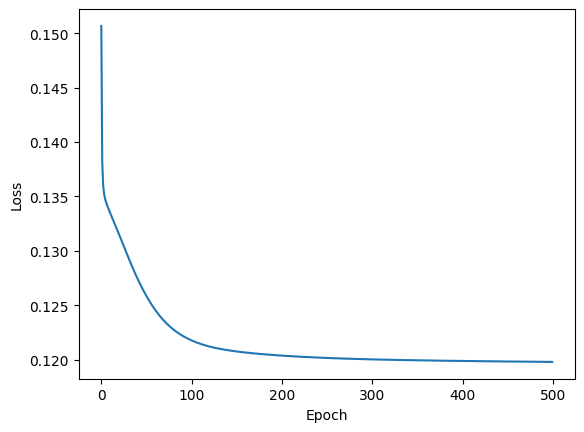

In [16]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
X_valid = np.array(x_valid)
Y_valid = np.array(y_valid)

outputs = NN.predict(X_valid)
acc = NN.accuracy(Y_valid, outputs)
WL_acc["NN"] = acc
print(f"Training accuracy is {acc}")

Training accuracy is 0.9359959037378393


### Weights voting prediction function

In [18]:
def weight_voting(test_df, forest, RFmodel, NNmodel, WL_acc={}):
    mean = sum(WL_acc.values()) / len(WL_acc)
    WL_weights = {key: value / mean for key, value in WL_acc.items()}
    preds = RFmodel.random_forest_predictions(test_df, forest)
    T_df = np.array(test_df.iloc[:,:-1])
    preds["NN"] = NNmodel.predict(T_df)
    p = preds.replace(0, -1)
    pred = p.mul(pd.Series(WL_weights), axis=1)
    result = []
    for idx in range(pred.shape[0]):
        y_hat = 1 if pred.iloc[idx].sum()>0 else 0
        result.append(y_hat)
    
    return result

In [19]:
result = weight_voting(test_x_y, forest, RFC, NN, WL_acc=WL_acc)
accuracy = NN.accuracy(y_test, result)
print(f"Training accuracy is {accuracy}")

Training accuracy is 0.9377880184331797


# 2. Ensemble of Deep Learning-Based Non-Tree Weak Learners

### Ensemble Learning (comparing RF & NN)

In [20]:
# 切割訓練集、驗證集與測試集
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(df, y, valid_proportion=0.1, test_proportion=0.2, random_state=1121225)
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

# 將特徵與label合併
train_x_y = pd.concat([x_train, y_train], axis=1)
valid_x_y = pd.concat([x_valid, y_valid], axis=1)
test_x_y = pd.concat([x_test, y_test], axis=1)

#### standard Random Forest

In [21]:
feature_number = 40
model_num = 5
forest = RFC.random_forest_algorithm(train_x_y, n_trees=model_num, n_features=feature_number, dt_max_depth=10)

100%|██████████| 5/5 [16:32<00:00, 198.54s/it]


In [22]:
pred_rf = RFC.EL_random_forest_predictions(test_x_y, forest)
rf_acc = RFC.calculate_accuracy(y_test, pred_rf)
print(f"Training accuracy is {rf_acc}")

Training accuracy is 0.28793309438470727


#### Random Forest using 2-layers MLP

In [23]:
ELNN = NeuralNetwork(input_size=feature_number, layers=10, output_size=2, random_seed=101)
losses = ELNN.Ensemble_Learning(x_train, y_train, 500, 1e-5, model_num, feature_number)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 Loss 0.6723
Epoch 50 Loss 0.1219
Epoch 100 Loss 0.1207
Epoch 150 Loss 0.1202
Epoch 200 Loss 0.1199
Epoch 250 Loss 0.1197
Epoch 300 Loss 0.1196
Epoch 350 Loss 0.1195
Epoch 400 Loss 0.1195
Epoch 450 Loss 0.1194


 20%|██        | 1/5 [00:11<00:44, 11.17s/it]

Epoch 0 Loss 0.1482
Epoch 50 Loss 0.1230
Epoch 100 Loss 0.1204
Epoch 150 Loss 0.1198
Epoch 200 Loss 0.1195
Epoch 250 Loss 0.1193
Epoch 300 Loss 0.1192
Epoch 350 Loss 0.1192
Epoch 400 Loss 0.1191
Epoch 450 Loss 0.1191


 40%|████      | 2/5 [00:21<00:32, 10.91s/it]

Epoch 0 Loss 0.1320
Epoch 50 Loss 0.1209
Epoch 100 Loss 0.1199
Epoch 150 Loss 0.1196
Epoch 200 Loss 0.1194
Epoch 250 Loss 0.1193
Epoch 300 Loss 0.1192
Epoch 350 Loss 0.1192
Epoch 400 Loss 0.1191
Epoch 450 Loss 0.1191


 60%|██████    | 3/5 [00:32<00:21, 10.82s/it]

Epoch 0 Loss 0.1080
Epoch 50 Loss 0.1189
Epoch 100 Loss 0.1189
Epoch 150 Loss 0.1189
Epoch 200 Loss 0.1188
Epoch 250 Loss 0.1188
Epoch 300 Loss 0.1187
Epoch 350 Loss 0.1187
Epoch 400 Loss 0.1186
Epoch 450 Loss 0.1186


 80%|████████  | 4/5 [00:43<00:10, 10.96s/it]

Epoch 0 Loss 0.1284
Epoch 50 Loss 0.1202
Epoch 100 Loss 0.1199
Epoch 150 Loss 0.1197
Epoch 200 Loss 0.1196
Epoch 250 Loss 0.1195
Epoch 300 Loss 0.1195
Epoch 350 Loss 0.1194
Epoch 400 Loss 0.1194
Epoch 450 Loss 0.1193


100%|██████████| 5/5 [00:54<00:00, 10.88s/it]


In [24]:
pred_nn = ELNN.EL_pred(x_test)
EL_accuracy = ELNN.accuracy(y_test, pred_nn)
print(f"Training accuracy is {EL_accuracy}")

Training accuracy is 0.9377880184331797
